Since diffusion-basics.ipynb became too long, starting afresh in this notebook

And trying U-net architecture again (as per Tejas' advice)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from diffusers import UNet2DModel
import matplotlib as plt

/Users/paraschopra/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paraschopra/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [27]:
import wandb
# start a new wandb run to track this script


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size 
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=img_size,            # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels to accept the conditioning information (the class)
            out_channels=1,            # the number of output channels
            layers_per_block=2,        # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),  
            down_block_types=(
                "DownBlock2D",          # a regular ResNet downsampling block
                "AttnDownBlock2D",      # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",        # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",
                "UpBlock2D",            # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_label):
        # Shape of x:
        bs, ch, w, h = x.shape
    
        # class conditioning is right shape to add as additional input channel
        class_cond = self.class_emb(class_label).view(bs, self.class_emb.embedding_dim, 1, 1)
        class_cond = class_cond.expand(bs, self.class_emb.embedding_dim, w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)
    
        # Feed the UNet with net_input, time step t, and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [14]:
import random
import matplotlib.pyplot as plt

def sample_image_multiple(num_samples=1):
    with torch.no_grad():
        # Generate initial pure Gaussian noise
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        for t in range(len(alpha_bar) - 1, -1, -1):
            z = torch.randn(num_samples, 1, 28, 28).to(device) if t > 0 else 0
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            #alpha_t_prev = alpha_bar[t - 1] if t > 0 else 1
            
            predicted_noise = model(x, torch.tensor([t]).expand(num_samples).to(device), y)
            
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * z
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [19]:
def train(epochs=100):
    running_loss = 0.0
    for epoch in range(epochs):
        i = 0
        for data, labels in trainloader:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding alpha_bar_t values for each example in the batch
            alpha_bar_t = alpha_bar[t]
            
            # Generate random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # Calculate the noisy data using the reparameterization trick
            noisy_data = torch.sqrt(alpha_bar_t).view(-1, 1, 1, 1) * data + torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1) * noise
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noisy_data - data)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if (i % 100) == 0:
                print(f"Epoch [{epoch+1}/1000], i: {i}, Loss: {loss.item():.4f}, Running loss: {running_loss/100}")
                wandb.log({"latest_loss": loss.item(), "avg_running_loss": running_loss / 100}, step=epoch * len(trainloader) + i)
                running_loss = 0.0
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4)

    wandb.finish()

In [20]:
num_steps = 200
beta_start = 0.0001
beta_end = 0.02
# Generate the beta values linearly from beta_start to beta_end
beta = torch.linspace(beta_start, beta_end, num_steps).to(device)
alpha = 1 - beta
# Pre-calculate alpha_bar_t for all timesteps
alpha_bar = torch.cumprod(alpha, dim=0)

In [29]:
learning_rate = 1e-5
epochs=100
batch_size=128

wandb.init(
    # set the wandb project where this run will be logged
    project="diffusion-with-unet")

config = {
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "num_steps":num_steps,
    "noise_schedule":"linear"
}
wandb.config.update(config)

In [30]:
class RescaleTransform(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        return (self.max_val - self.min_val) * tensor + self.min_val # convert 0-1 range to -1 to +1 range

transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleTransform(-1, 1)
])

trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [31]:
model = DiffusionModel(img_size=28, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 0.6008, Running loss: 0.00600757896900177
Epoch [1/1000], i: 100, Loss: 0.3079, Running loss: 0.40161909729242323
Epoch [1/1000], i: 200, Loss: 0.2210, Running loss: 0.24328501045703887
Epoch [1/1000], i: 300, Loss: 0.1785, Running loss: 0.18744218453764916
Epoch [1/1000], i: 400, Loss: 0.1526, Running loss: 0.15950467824935913


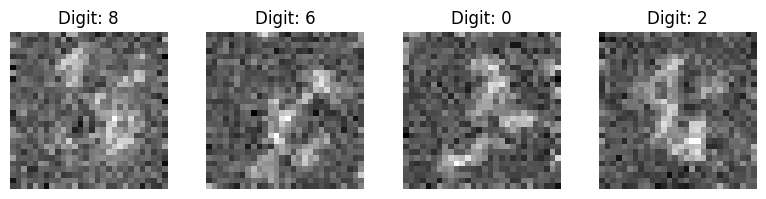

Epoch [2/1000], i: 0, Loss: 0.1226, Running loss: 0.09818533524870872
Epoch [2/1000], i: 100, Loss: 0.1110, Running loss: 0.12907232120633125
Epoch [2/1000], i: 200, Loss: 0.1038, Running loss: 0.1191976584494114
Epoch [2/1000], i: 300, Loss: 0.1029, Running loss: 0.11041521981358528
Epoch [2/1000], i: 400, Loss: 0.0974, Running loss: 0.10332089856266975
Epoch [3/1000], i: 0, Loss: 0.0886, Running loss: 0.06666521117091179
Epoch [3/1000], i: 100, Loss: 0.0868, Running loss: 0.09218344010412693
Epoch [3/1000], i: 200, Loss: 0.0821, Running loss: 0.0851761582493782
Epoch [3/1000], i: 300, Loss: 0.0827, Running loss: 0.08101918533444405
Epoch [3/1000], i: 400, Loss: 0.0724, Running loss: 0.0771262489259243
Epoch [4/1000], i: 0, Loss: 0.0834, Running loss: 0.05102299589663744
Epoch [4/1000], i: 100, Loss: 0.0746, Running loss: 0.07068782400339842
Epoch [4/1000], i: 200, Loss: 0.0749, Running loss: 0.06868029985576868
Epoch [4/1000], i: 300, Loss: 0.0699, Running loss: 0.0659103986248374
Ep

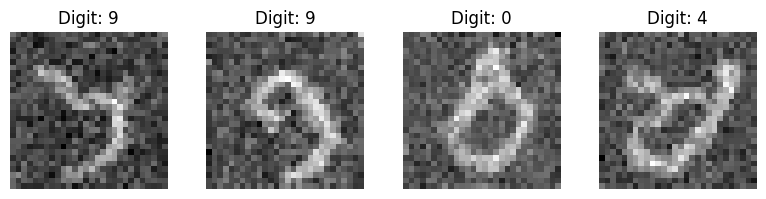

Epoch [7/1000], i: 0, Loss: 0.0517, Running loss: 0.034830374158918855
Epoch [7/1000], i: 100, Loss: 0.0497, Running loss: 0.049514493383467195
Epoch [7/1000], i: 200, Loss: 0.0511, Running loss: 0.04923527292907238
Epoch [7/1000], i: 300, Loss: 0.0485, Running loss: 0.048422541618347165
Epoch [7/1000], i: 400, Loss: 0.0472, Running loss: 0.047518138289451596
Epoch [8/1000], i: 0, Loss: 0.0475, Running loss: 0.032857133746147155
Epoch [8/1000], i: 100, Loss: 0.0422, Running loss: 0.047007990889251235
Epoch [8/1000], i: 200, Loss: 0.0444, Running loss: 0.04669646829366684
Epoch [8/1000], i: 300, Loss: 0.0422, Running loss: 0.04563029665499926
Epoch [8/1000], i: 400, Loss: 0.0420, Running loss: 0.045703039392828944
Epoch [9/1000], i: 0, Loss: 0.0414, Running loss: 0.031168155595660208
Epoch [9/1000], i: 100, Loss: 0.0427, Running loss: 0.044346106387674805
Epoch [9/1000], i: 200, Loss: 0.0397, Running loss: 0.044819296710193156
Epoch [9/1000], i: 300, Loss: 0.0392, Running loss: 0.043888

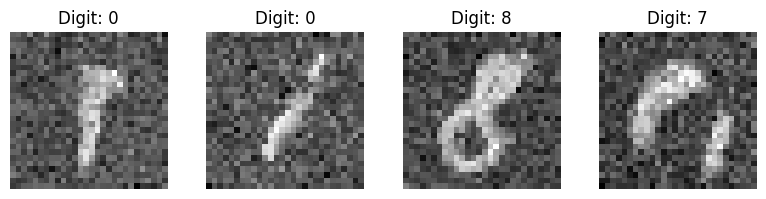

Epoch [12/1000], i: 0, Loss: 0.0395, Running loss: 0.02862539242953062
Epoch [12/1000], i: 100, Loss: 0.0429, Running loss: 0.040770497135818005
Epoch [12/1000], i: 200, Loss: 0.0393, Running loss: 0.04102761685848236
Epoch [12/1000], i: 300, Loss: 0.0462, Running loss: 0.041186799369752405
Epoch [12/1000], i: 400, Loss: 0.0454, Running loss: 0.04034853637218475
Epoch [13/1000], i: 0, Loss: 0.0390, Running loss: 0.027958563677966595
Epoch [13/1000], i: 100, Loss: 0.0409, Running loss: 0.038830115906894204
Epoch [13/1000], i: 200, Loss: 0.0397, Running loss: 0.03918939042836428
Epoch [13/1000], i: 300, Loss: 0.0398, Running loss: 0.03971851507201791
Epoch [13/1000], i: 400, Loss: 0.0413, Running loss: 0.03954123850911856
Epoch [14/1000], i: 0, Loss: 0.0348, Running loss: 0.027529326155781745
Epoch [14/1000], i: 100, Loss: 0.0405, Running loss: 0.03923853699117899
Epoch [14/1000], i: 200, Loss: 0.0385, Running loss: 0.03907211035490036
Epoch [14/1000], i: 300, Loss: 0.0412, Running loss:

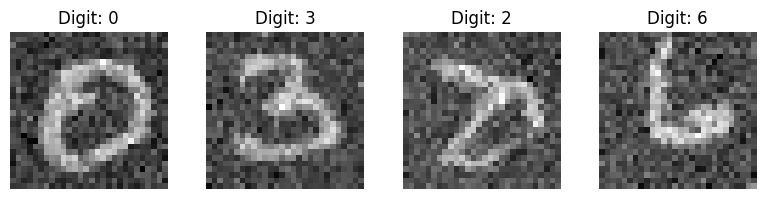

Epoch [17/1000], i: 0, Loss: 0.0406, Running loss: 0.025858400929719208
Epoch [17/1000], i: 100, Loss: 0.0370, Running loss: 0.0376339815184474
Epoch [17/1000], i: 200, Loss: 0.0369, Running loss: 0.0378344370238483
Epoch [17/1000], i: 300, Loss: 0.0352, Running loss: 0.03717700377106667
Epoch [17/1000], i: 400, Loss: 0.0362, Running loss: 0.03730457156896591
Epoch [18/1000], i: 0, Loss: 0.0391, Running loss: 0.025879743993282318
Epoch [18/1000], i: 100, Loss: 0.0349, Running loss: 0.036492374427616596
Epoch [18/1000], i: 200, Loss: 0.0408, Running loss: 0.037333241757005454
Epoch [18/1000], i: 300, Loss: 0.0387, Running loss: 0.03704164147377014
Epoch [18/1000], i: 400, Loss: 0.0376, Running loss: 0.03693888271227479
Epoch [19/1000], i: 0, Loss: 0.0358, Running loss: 0.02518702283501625
Epoch [19/1000], i: 100, Loss: 0.0325, Running loss: 0.03653862627223134
Epoch [19/1000], i: 200, Loss: 0.0325, Running loss: 0.03618220243602991
Epoch [19/1000], i: 300, Loss: 0.0381, Running loss: 0.

KeyboardInterrupt: 

In [32]:
train(epochs)

In [33]:
wandb.finish()

avg_running_loss,▁█▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
latest_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_running_loss,0.03641
latest_loss,0.03718
